# Analysis of the MoNuSAC 2020 challenge evaluation and results: metric implementation errors

## Supplementary materials

Adrien Foucart, Olivier Debeir, Christine Decaestecker.

The supplementary materials contain:

0. Links to all the data necessary to reproduce the results
1. Error in the "Panoptic Quality" computation (section II.A of the article)
2. Error in the "Nuclei-Type and Organ Level" PQ (section II.B of the article)
3. Missed false positives (section III of the article)
4. Problem with the aggregation method (section IV of the article)

## Links to the data necessary to reproduce the results:

- [Res] Official challenge results: https://monusac-2020.grand-challenge.org/Results/
- [PrePub] Pre-challenge publication: https://www.researchgate.net/publication/339227864_Multi-organ_Nuclei_Segmentation_and_Classification_Challenge_2020?channel=doi&linkId=5e49f74192851c7f7f40f1d1&showFulltext=true
- [PostPub] Post-challenge publication: https://ieeexplore.ieee.org/document/9446924/
- [Suppl] Post-challenge publication's supplementary materials: https://drive.google.com/file/d/1kdOl3s6uQBRv0nToSIf1dPuceZunzL4N/view
- [GitHub] GitHub with challenge's evaluation code & annotation parsing: https://github.com/ruchikaverma-iitg/MoNuSAC/
- [Masks] Ground truth masks & several team's predictions : https://monusac-2020.grand-challenge.org/Data/
- [Format] Example results showing expected format, provided by the organizers: https://drive.google.com/file/d/1f_dpKpS4z8DGzw_xHvxxPYMSW0ReHW_R/view

To reproduce all the results from this notebook, the Team's color-coded prediction masks should be downloaded and put in the **./Teams** directory (or the code should be updated to point to the desired directory as needed), and the ground truth data should be in **./MoNuSAC Testing Data and Annotations**.

# 1. Error in the "Panoptic Quality" computation

In the code provided in https://github.com/ruchikaverma-iitg/MoNuSAC/blob/master/PQ_metric.ipynb, we find the implementation of the "PQ" metric computation.

The PQ is defined as $\frac{\sum_{TP}IoUs}{|TP|} x \frac{|TP|}{|TP|+0.5*|FP|+0.5*|FN|}$ or, in words, the "average IoUs of the true positives" (segmentation score) multiplied by the detection F1-score. A "true positive" is defined in [PrePub] and [PostPub] as a (prediction, ground truth) object pair with $IoU > 0.5$.

The code of the method in [GitHub] is as follows: 

In [1]:
# Compute Panoptic quality metric for each image
def Panoptic_quality(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)
    
    return PQ

In the code, first the matched instances are stored in a dictionnary. In line 28:

```matched_instance[i] = j, IOU```

With ```i``` the index of the ground truth object and ```j``` the index of the predicted object.

Once all matches have been found, the code creates a list of existing predicted indices ```pred_indx_list``` (line 32-33). We then loop over all ground truth objects. In the ground truth object ```indx``` is associated with a match (```matched_instances[indx]``` exists), the associated predicted object is removed from the ```pred_indx_list```, a True Positive counter is incremented, and the IoU is added to a running sum. If no match exists, a False Negative is noted. At the end, the remaining indices in the ```pred_indx_list``` are counted as False Positives.

The error appears in line 41:

```pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == [indx][0]))```

Which should read:

```pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == matched_instances[indx][0]))```

Because of that error, the index removed from ```pred_indx_list``` is not the **predicted object index** but the **ground truth object index** (as ```[indx][0] == indx```). As np.delete doesn't raise an error if the index doesn't exist, this means that if the **ground truth object index** doesn't exit in the ```pred_indx_list```, **no index will be removed from the prediction list**, resulting in an erroneous False Positive.

The resulting error will be particularly large if:
* There are more Ground Truth objects than Predicted Objects -> it is then likely that some of the matches will happen on Ground Truth objects with an index > than any existing predicted objects, resulting in erroneous false positives.
* The indexing of the ground truth objects & predicted objects are not "aligned" (for instance -> if the ground truth objects are labeled ```[1,2,3,4]``` and the predicted objects are labelled ```[5,6,7,8]```, four "false positives" will be counted even if the objects are perfectly matched.

Unfortunately, the latter scenario is not unlikely at all, as there are two different strategies when generating the per-class prediction masks. As each class' prediction has to be sent separately, it makes sense to reset the label count for each class, so that labels for every prediction the "n-ary mask" will always have a set of objects starting at label 1. Conversely, as the goal of the challenge is to provide "segmentation and classification" for all classes in an image, it would also make sense to provide a unique label for each object in the image, and then to separate the objects by class. In that case, the labels could follow each other from class to class (for instance: Epithelial = [1,2...N], Lymphocyte = [N+1,N+2...M], etc., or they could be completely mixed.

Nothing in the provided instructions require one strategy over the others. The provided example .mat files illustrating the format chose the "labels following each other" method, so that the labels for a given class will typically only start at 1 for the first class present in the image. The code building the "n-ary masks" from the .xml annotations for the ground truth follow that same rule.

## Demonstration on fabricated data

We construct a "ground truth" image with three objects, and a "prediction" image with the same three objects, but given different labels. The correct PQ should be 1, but the challenge code finds three false positives because of the disalignment of the labels, leading to an incorrect PQ of $\frac{3}{3+1.5} = \frac{2}{3}$ 

In [2]:
import numpy as np

gt = np.zeros((100,100))
pred = np.zeros((100,100))

gt[10:20,10:20] = 1
gt[10:20,30:40] = 2
gt[50:60,50:60] = 3

pred[10:20,10:20] = 4
pred[10:20,30:40] = 5
pred[50:60,50:60] = 6

PQ = Panoptic_quality(gt, pred)
print(PQ)

0.6666666666666666


## Demonstration on challenge data

Using an image with multiple classes to better see the effect of the "alignment" problem.

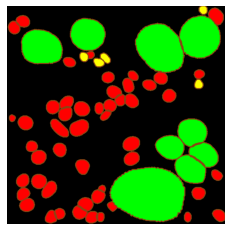

In [3]:
%matplotlib inline
from skimage.io import imread
from matplotlib import pyplot as plt

colorcoded_prediction_mask = "./Teams/SJTU_426/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_6_mask.png.tif"
testing_image = "./MoNuSAC Testing Data and Annotations/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_6.svs"
testing_annotations = "./MoNuSAC Testing Data and Annotations/TCGA-2Z-A9JG-01Z-00-DX1/TCGA-2Z-A9JG-01Z-00-DX1_6.xml"

cc_mask = imread(colorcoded_prediction_mask)
plt.figure()
plt.imshow(cc_mask)
plt.axis('off')
plt.show()

The code below is taken from [GitHub]'s n-ary_mask_generation.ipynb file to generate n-ary_masks from the xml annotations.

In [4]:
import xml.etree.ElementTree as ET
import openslide
from shapely.geometry import Polygon
import numpy as np
from skimage import draw

# Read xml file
xml_file_name = testing_annotations
tree = ET.parse(xml_file_name)
root = tree.getroot()

# Read SVS
img = openslide.OpenSlide(testing_image)

n_ary_masks = {}
count = 0
gt = 0

#Generate n-ary mask for each cell-type                       
for k in range(len(root)):
    label = [x.attrib['Name'] for x in root[k][0]]
    label = label[0]

    for child in root[k]:
        for x in child:
            r = x.tag
            if r == 'Attribute':
                count = count+1
                print(count)
                label = x.attrib['Name']
                n_ary_mask = np.transpose(np.zeros((img.read_region((0,0),0,img.level_dimensions[0]).size))) 
                print(label)

                # Add label to dictionary
                if label not in n_ary_masks:
                    n_ary_masks[label] = n_ary_mask 
            if r == 'Region':
                regions = []
                vertices = x[1]
                coords = np.zeros((len(vertices), 2))
                for i, vertex in enumerate(vertices):
                    coords[i][0] = vertex.attrib['X']
                    coords[i][1] = vertex.attrib['Y']        
                regions.append(coords)
                poly = Polygon(regions[0])  

                vertex_row_coords = regions[0][:,0]
                vertex_col_coords = regions[0][:,1]
                fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, n_ary_mask.shape)
                gt = gt+1 #Keep track of giving unique valu to each instance in an image
                n_ary_masks[label][fill_row_coords, fill_col_coords] = gt

1
Epithelial
2
Lymphocyte
3
Neutrophil
4
Macrophage
5
Ambiguous


## Experiment on prediction mask

Below, we perform the following experiment:

* From the ground truth n-ary masks, we take the "Lymphocyte" mask.
* We extract the "Lymphocyte" mask from the color-coded image by taking all the yellow pixels (we can check the colors used in the color-coded version of the ground truth in [Masks]). Note that this will slightly understimate the segmented region, as the added borders in the color-coded image are not taken into account.
* We remove the "Ambiguous" regions from both.
* We re-label this prediction mask.
* We compute the PQ using the challenge-provided version and using our correction.
* We offset the labels of the prediction mask so that we incrementally modify the "alignment" of the two label lists, and recompute both PQ.

In [5]:
# Compute Panoptic quality metric for each image
def Panoptic_quality_corrected(ground_truth_image,predicted_image):
    TP = 0
    FP = 0
    FN = 0
    sum_IOU = 0
    matched_instances = {}# Create a dictionary to save ground truth indices in keys and predicted matched instances as velues
                        # It will also save IOU of the matched instance in [indx][1]

    # Find matched instances and save it in a dictionary
    for i in np.unique(ground_truth_image):
        if i == 0:
            pass
        else:
            temp_image = np.array(ground_truth_image)
            temp_image = temp_image == i
            matched_image = temp_image * predicted_image
        
            for j in np.unique(matched_image):
                if j == 0:
                    pass
                else:
                    pred_temp = predicted_image == j
                    intersection = sum(sum(temp_image*pred_temp))
                    union = sum(sum(temp_image + pred_temp))
                    IOU = intersection/union
                    if IOU> 0.5:
                        matched_instances [i] = j, IOU 
                        
    # Compute TP, FP, FN and sum of IOU of the matched instances to compute Panoptic Quality               
                        
    pred_indx_list = np.unique(predicted_image)
    pred_indx_list = np.array(pred_indx_list[1:])

    # Loop on ground truth instances
    for indx in np.unique(ground_truth_image):
        if indx == 0:
            pass
        else:
            if indx in matched_instances.keys():
                pred_indx_list = np.delete(pred_indx_list, np.argwhere(pred_indx_list == matched_instances[indx][0]))
                TP = TP+1
                sum_IOU = sum_IOU+matched_instances[indx][1]
            else:
                FN = FN+1
    FP = len(np.unique(pred_indx_list))
    PQ = sum_IOU/(TP+0.5*FP+0.5*FN)
    
    return PQ

Ground truth labels: [ 0. 48. 49. 50. 51. 52.]
Prediction labels: [0 1 2 3 4 5]
Challenge PQ: 0.385
Corrected PQ: 0.501


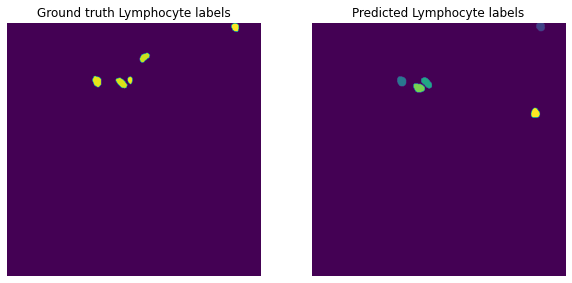

Prediction labels: [ 0 44 45 46 47 48]
Challenge PQ: 0.385
Corrected PQ: 0.501
Prediction labels: [ 0 45 46 47 48 49]
Challenge PQ: 0.417
Corrected PQ: 0.501
Prediction labels: [ 0 46 47 48 49 50]
Challenge PQ: 0.455
Corrected PQ: 0.501
Prediction labels: [ 0 47 48 49 50 51]
Challenge PQ: 0.455
Corrected PQ: 0.501
Prediction labels: [ 0 48 49 50 51 52]
Challenge PQ: 0.501
Corrected PQ: 0.501
Prediction labels: [ 0 49 50 51 52 53]
Challenge PQ: 0.501
Corrected PQ: 0.501
Prediction labels: [ 0 50 51 52 53 54]
Challenge PQ: 0.455
Corrected PQ: 0.501
Prediction labels: [ 0 51 52 53 54 55]
Challenge PQ: 0.417
Corrected PQ: 0.501
Prediction labels: [ 0 52 53 54 55 56]
Challenge PQ: 0.417
Corrected PQ: 0.501
Prediction labels: [ 0 53 54 55 56 57]
Challenge PQ: 0.385
Corrected PQ: 0.501


In [6]:
from skimage.measure import label

mask_ambiguous = n_ary_masks['Ambiguous']==0

gt = n_ary_masks['Lymphocyte']*mask_ambiguous
print(f"Ground truth labels: {np.unique(gt)}")

pred = label((cc_mask[...,0]==255) & (cc_mask[...,1] == 255) & (cc_mask[...,2] == 0))*mask_ambiguous
print(f"Prediction labels: {np.unique(pred)}")

print(f"Challenge PQ: {Panoptic_quality(gt, pred):.3f}")
print(f"Corrected PQ: {Panoptic_quality_corrected(gt, pred):.3f}")

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(gt)
plt.axis('off')
plt.title('Ground truth Lymphocyte labels')
plt.subplot(1,2,2)
plt.imshow(pred)
plt.axis('off')
plt.title('Predicted Lymphocyte labels')
plt.show()

for offset in [43,44,45,46,47,48,49,50,51,52]:
    pred_ = pred.copy()
    pred_[pred>0] += offset
    print(f"Prediction labels: {np.unique(pred_)}")
    print(f"Challenge PQ: {Panoptic_quality(gt, pred_):.3f}")
    print(f"Corrected PQ: {Panoptic_quality_corrected(gt, pred_):.3f}")

As we can see, the code from the challenge returns a PQ that vary between 0.385 and 0.501 depending on the alignment of the labels indices, which should have no impact at all on the results. The corrected version, meanwhile, stays at 0.501 throughout these changes.

Of interest, if we look at the history of the *PQ_metric.ipynb* file on [GitHub], we can see a point where the code was run on several team's results (https://github.com/ruchikaverma-iitg/MoNuSAC/blob/48c250d7a48e18bde8cedafe1080a5e63ff3bc8d/PQ_metric.ipynb). From there, we can find the results computed for the image & class of the team that we used in the example above:

```.\TCGA-2Z-A9JG-01Z-00-DX1\TCGA-2Z-A9JG-01Z-00-DX1_6\Lymphocyte\27_mask.mat
['D:\\Personal improvisation\\IITB\\MoNuSAC\\Submissions\\Mask_files\\Predicted_updated_masks\\SJTU_426/.\\TCGA-2Z-A9JG-01Z-00-DX1\\TCGA-2Z-A9JG-01Z-00-DX1_6/Lymphocyte\\11.mat']
0.38075071325851917```

The result of 0.381 is very close to our "worst case scenario" of 0.385. The difference is likely due to a difference in the IoU. It's likely that the size of the objects was sligthly overestimated by the team's algorithm, and that the mask we retrieved from the color-coded version is therefore a bit closer to the ground truth's shape.

## Test of corrected method on the fabricated data

In [7]:
gt = np.zeros((100,100))
pred = np.zeros((100,100))

gt[10:20,10:20] = 1
gt[10:20,30:40] = 2
gt[50:60,50:60] = 3

pred[10:20,10:20] = 4
pred[10:20,30:40] = 5
pred[50:60,50:60] = 6

PQ = Panoptic_quality_corrected(gt, pred)
print(PQ)

1.0


The expected result of 1.0 is returned.

# 2. Error in the "Nuclei-Type and Organ Level" PQ

In the supplementary materials [Suppl], we find a detailed table with the average PQ per-organ and per-class for 19 participants. Using the results printed in the PQ_metric.ipynb's file history (see above), we can check how those results were computed for the SJTU_426 team ("L2" in [Suppl]).

We have taken all the lines in that "result dump" corresponding to the SJTU_426 team and put them in a file. The code to parse that file into the results per organ & per class can be found in the result_parser.py file.

In [8]:
from result_parser import parse_results

parser = parse_results('./SJTU_426 Full Results')
results_per_organ_and_class = parser.get_results_per_organ_and_class()

We have in those results the "PQ" for each image (corresponding to a region of the patient's whole slide) and each class, with the corresponding organ from the reference of patient id to organ provided in [Suppl]. We can therefore display the same information shown in Table S2 of [Suppl]:

In [9]:
for organ, results_organ in results_per_organ_and_class.items():
    print(organ)
    for cl, results_organ_class in results_organ.items():
        avg_class = []
        for pat_id, values in results_organ_class.items():
            avg_class += values
        print(f"{cl} avg PQ: {sum(avg_class)/len(avg_class):.3f}")
    print('--')

Lung
Epithelial avg PQ: 0.614
Lymphocyte avg PQ: 0.529
Neutrophil avg PQ: 0.566
Macrophage avg PQ: 0.621
--
Kidney
Epithelial avg PQ: 0.583
Lymphocyte avg PQ: 0.542
Neutrophil avg PQ: 0.441
Macrophage avg PQ: 0.465
--
Breast
Epithelial avg PQ: 0.667
Lymphocyte avg PQ: 0.608
Neutrophil avg PQ: 0.446
Macrophage avg PQ: 0.342
--
Prostate
Epithelial avg PQ: 0.705
Lymphocyte avg PQ: 0.542
Neutrophil avg PQ: 0.612
Macrophage avg PQ: 0.426
--


Looking at Table S2 in [Suppl], we can see that the values are identical to the results of L2, proving that these are indeed the values computed for the challenge results.

There is, however, one key difference: the results for the Macrophage class and Neutrophil class are inverted.

We can see in that version of the [PQ_metric.ipynb file](https://github.com/ruchikaverma-iitg/MoNuSAC/blob/48c250d7a48e18bde8cedafe1080a5e63ff3bc8d/PQ_metric.ipynb) that the order of the columns in which the results are stored is "Epithelial - Lymphocyte - Neutrophil - Macrophage", whereas the result's table in [Suppl] puts Macrophage before Neutrophil, so this is likely to be an error in the collation of the final results.

# 3. Missed false positives

In [10]:
from metrics_reproduction import generate_masks, nary_from_colormap_no_border, match_strict_iou_class, match_strict_iou_class_with_error, compute_PQc

In [11]:
gt_dir = "./MoNuSAC Testing Data and Annotations"
teams_dir = "./Teams"

First, we generate all the n-ary masks from the colorcoded predictions and from the testing data:

In [12]:
import os
from skimage.io import imread

team_dir = os.path.join(teams_dir,"SJTU_426") #contains the color-coded version of the predictions
patients = os.listdir(team_dir)

for ip,patient in enumerate(patients):
    print(f"Processing patient {ip+1}/{len(patients)}",end='\r')
    patient_dir = os.path.join(team_dir, patient)
    masks = [f for f in os.listdir(patient_dir) if 'mask.png.tif' in f]
    for m in masks:
        f = m.replace('_mask.png.tif','')
        mask_cl = imread(os.path.join(patient_dir,m))
        nary_mask = nary_from_colormap_no_border(mask_cl)
        
        np.save(os.path.join(patient_dir, f"{f}_nary.npy"), nary_mask)

In [13]:
generate_masks(gt_dir)

25 patients in directory: ./MoNuSAC Testing Data and Annotations


Using these n-ary masks, we can now recompute the PQ metric, using the "per-sub-image, per-class" $PQ_c^i$ computation and two scenarios. In the first one, we count the $PQ_c^i$ only if there is at least one object of that class in the ground truth. In the second scenario, we count the $PQ_c^i$ if there is at least one object of that class in either the ground truth or the prediction. To compare with the challenge results, we use the original matching method (with the error).

In [14]:
import os
import statistics
import numpy as np

all_PQs = []
all_PQs_full = []

team_dir = os.path.join(teams_dir,"SJTU_426") #contains the color-coded version of the predictions
patients = os.listdir(team_dir)

for ip,patient in enumerate(patients):
    print(f"Processing patient {ip+1}/{len(patients)}",end='\r')
    patient_dir = os.path.join(team_dir, patient)
    masks = [f for f in os.listdir(patient_dir) if '_nary.npy' in f]
    for m in masks:
        pred_mask = np.load(os.path.join(patient_dir,m))
        gt_mask = np.load(f'{os.path.join(gt_dir, patient)}/{m}')
        mask_nonambiguous = gt_mask[...,4]==0 # ambiguous regions
        
        PQcs = []
        PQcs_full = []
        for c in range(4):
            if gt_mask[...,c].max()==0 and pred_mask[...,c].max()==0: continue

            IOUs,TP,FP,FN = match_strict_iou_class_with_error(gt_mask[...,c]*mask_nonambiguous, pred_mask[...,c]*mask_nonambiguous)
            PQc = compute_PQc(IOUs,TP,FP,FN)
            if gt_mask[...,c].max() > 0:
                PQcs.append(PQc)
            if gt_mask[...,c].max() > 0 or pred_mask[...,c].max() > 0:
                PQcs_full.append(PQc)
        
        all_PQs.append(statistics.mean(PQcs))
        all_PQs_full.append(statistics.mean(PQcs_full))

In [15]:
print(f"Avg PQ (with FP ignored if no gt object): {statistics.mean(all_PQs):.3f}")
print(f"Avg PQ (with FP fully accounted for): {statistics.mean(all_PQs_full):.3f}")

Avg PQ (with FP ignored if no gt object): 0.554
Avg PQ (with FP fully accounted for): 0.424


Computing the number of affected images & objects:

In [16]:
import os
import statistics
import numpy as np

all_PQs = []
all_PQs_full = []

team_dir = os.path.join(teams_dir,"SJTU_426") #contains the color-coded version of the predictions
patients = os.listdir(team_dir)

n_masks = 0
total_masks = 0
n_objects = 0

for ip,patient in enumerate(patients):
    print(f"Processing patient {ip+1}/{len(patients)}",end='\r')
    patient_dir = os.path.join(team_dir, patient)
    masks = [f for f in os.listdir(patient_dir) if '_nary.npy' in f]
    for m in masks:
        pred_mask = np.load(os.path.join(patient_dir,m))
        gt_mask = np.load(f'{os.path.join(gt_dir, patient)}/{m}')
        mask_nonambiguous = gt_mask[...,4]==0 # ambiguous regions
        
        for c in range(4):
            gt_im = gt_mask[...,c]*mask_nonambiguous
            pred_im = pred_mask[...,c]*mask_nonambiguous
                
            if gt_im.max()==0 and pred_im.max()>0:
                n_masks += 1
                n_objects += len(np.unique(pred_im))-1
            
            if gt_im.max()>0:
                total_masks += 1

print(f"Missed false positives for the SJTU team: {n_objects} objects in {n_masks} masks (for reference, there are {total_masks} gt nary-masks in the test set)")

Missed false positives for the SJTU team: 439 objects in 66 masks (for reference, there are 162 gt nary-masks in the test set)


# 4. Problem with the aggregation method

Per the [PostPub], the PQ was computed per-class and per-image:

> Participants submitted a separate output file for each of the 25 test images. $PQ^i$ was assigned 0 if the file for the i-th test image was not submitted. Arithmetic mean of the 25 $PQ^i$ scores formed the final average panoptic quality (a-PQ) score for ranking the participants.

The "25", however, doesn't correspond to the number of image (in the sense of individual .svs file in the training set), but to the number of patients. [PrePub] refers to the "individual images" as "sub-images", as they are regions taken from a larger image, with each patient having a single "large" image.

This implies that there is an aggregation made at the patient level of the results obtained per-image. The published code, however, doesn't provide that aggregation method, and appears to compute the PQ per sub-image.

This is confirmed in the results shown above, where to get the exact values from the result table we simply averaged the PQs computed per "sub-image". This is a problem, as sub-images vary wildly in their size and number of objects, with some very small ~100x100 pixels images with one or two objects, and large ~1500x1500 pixels with hundreds of nuclei.

To check if this computation per-sub-image was the one used in the published challenge results, we can compute the global average PQ based on the "result dump" by :
* Compiling the results of each class per sub-image.
* Computing the avg PQ per sub-image (using a simple average of the PQc of the classes that were present in the ground truth).
* Computing the global avg PQ as the avg of those sub-image PQs.

In [17]:
all_scores = parser.all_scores

scores_per_image = {}
for patient, scores in all_scores.items():
    for img_id, cl_idx, score in scores:
        if img_id not in scores_per_image: scores_per_image[img_id] = [None,None,None,None]
        scores_per_image[img_id][cl_idx] = score

per_image_avg = []
for img_id,pqc in scores_per_image.items():
    n = 0
    s = 0
    for pq in pqc:
        if pq is None: continue
        s += pq
        n += 1
    per_image_avg.append(s/n)

print(sum(per_image_avg)/len(per_image_avg))

0.5792538515659122


This corresponds exactly to the results published for the SJTU_426 team [in the challenge results](https://monusac-2020.grand-challenge.org/Results/), confirming that the code in the PQ_metric notebook was the one used to compute the challenge results.